Notes about how to condition and process the HAT-P-37 data

In [285]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
from astropy.units import Quantity
from astropy.time import Time
from scipy.interpolate import interp1d, make_lsq_spline
from scipy.optimize import curve_fit

# From https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract
orbital_period = 2.79744256 #±0.00000041 
epoch_0 = 2457938.84392 # ±0.00016
# convert t0 to TESS BJD (BTJD)
epoch_0_BTJD = epoch_0 - 2457000.

In [15]:
# Check which lightcurves are available for HAT-P-37
# I can't seem to look the system up except by its TIC number
# exptime='short' only keeps the 120-s exposures
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

# LightCurveCollection of 11 objects:
#     0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
#     10: <TessLightCurve LABEL="TIC 267572272" SECTOR=82 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

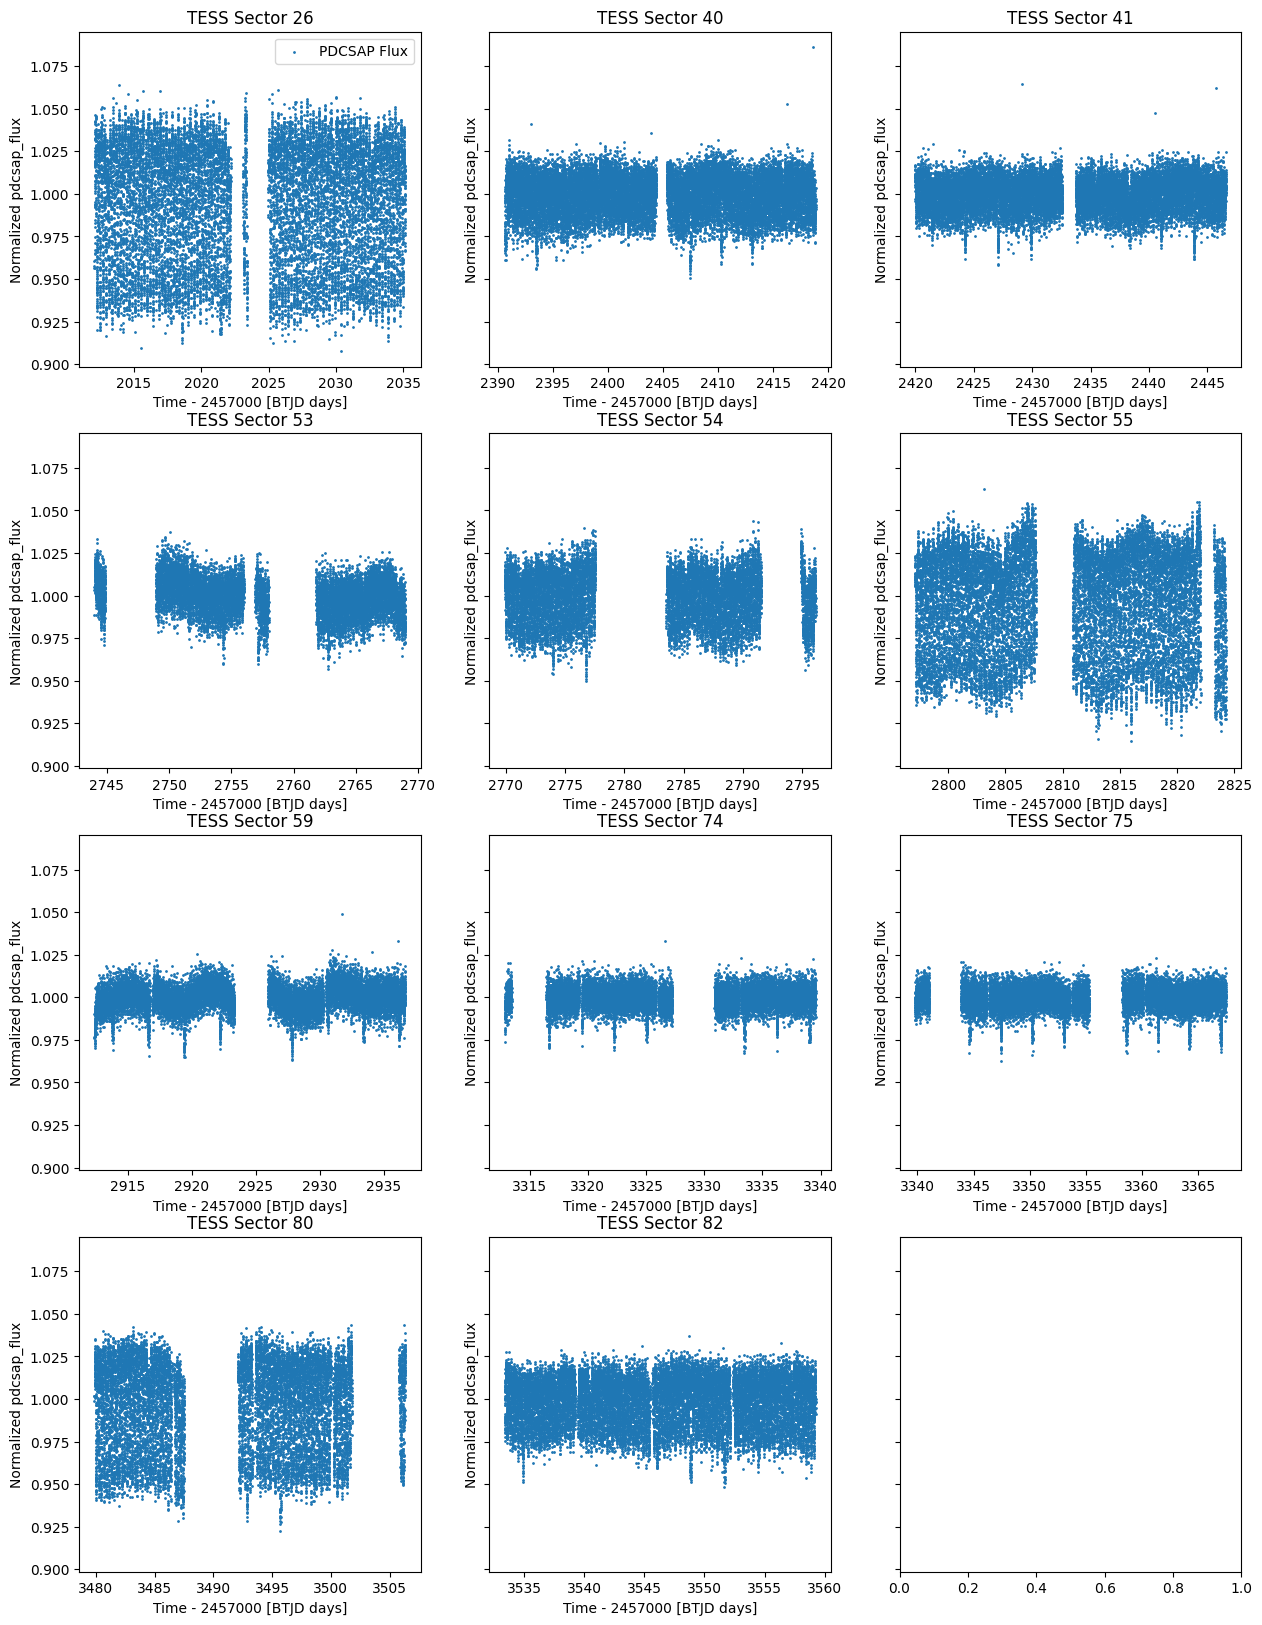

In [16]:
# PDCSAP_FLUX is the mission's estimate for lightcurve with instrument effects taken out
# We can compare the PDCSAP flux to the SAP flux (Simple Apeture Photometry) using the following:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
for i, lc in enumerate(tess_lc_collection):
    tess_lc_collection[i].scatter(column='pdcsap_flux', label='PDCSAP Flux', normalize=True, ax=axs[ax_indices[i]])
    # lc.plot(column='sap_flux', normalize=True, ax=axs[0])
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    if i == 0:
        axs[ax_indices[i]].legend()  # keep the legend in the first plot
    else:
        axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

# klc.plot(column='sap_flux', label='SAP Flux', normalize=True, ax=ax);

# ax = tess_lc_collection.plot(normalize=True)
# ax.get_legend().remove()


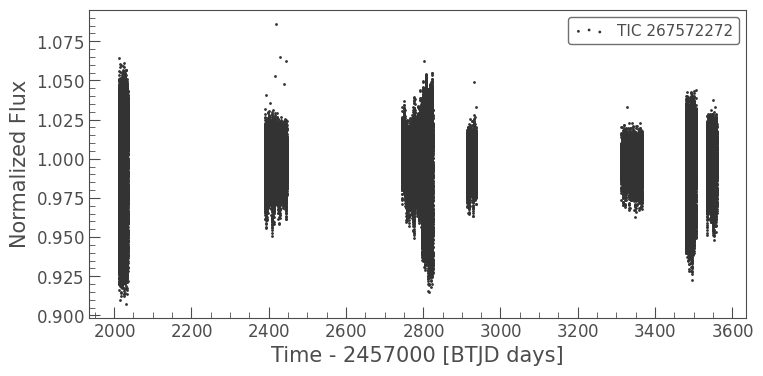

In [17]:
# Make a single lightcurve out of the collection of lightcurves
composite_lc = tess_lc_collection.stitch()
composite_lc.scatter();


Composite period:  0.21773270629361255 d
Composite EB:  0.4354654125872251 d


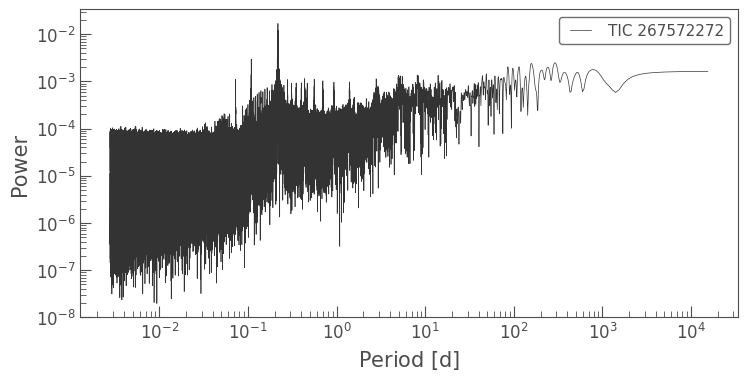

In [18]:
# Calculate periodogram using ALL(?) the light curves  - includes "misbehaved" sectors
composite_pg = composite_lc.to_periodogram(oversample_factor=10)
ax = composite_pg.plot(view='period', scale='log');
# Find peak - 0.21769631036042894 d
# 
# BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
# so we need to fold on twice on the period
composite_average = composite_pg.period_at_max_power
composite_EB_period = 2.* composite_average
print("Composite period: ", composite_average)
print("Composite EB: ", composite_EB_period)

In [19]:
# calculate the t0 for the eclipsing binary (from https://iopscience.iop.org/article/10.3847/1538-4365/ab9cae#apjsab9caes5)
HJD_shift = 2400000.5
EB_t0_HJD = 58641.4289616 + HJD_shift
# print(EB_t0_HJD)
EB_t0_BJD = 2458641.929750  # calculated using the Ohio State Applet (https://astroutils.astronomy.osu.edu/time/hjd2bjd.html)
# finally convert t0 to TESS BJD (BTJD)
EB_t0_BTJD = EB_t0_BJD - 2457000.
print(EB_t0_BTJD)

1641.9297500001267


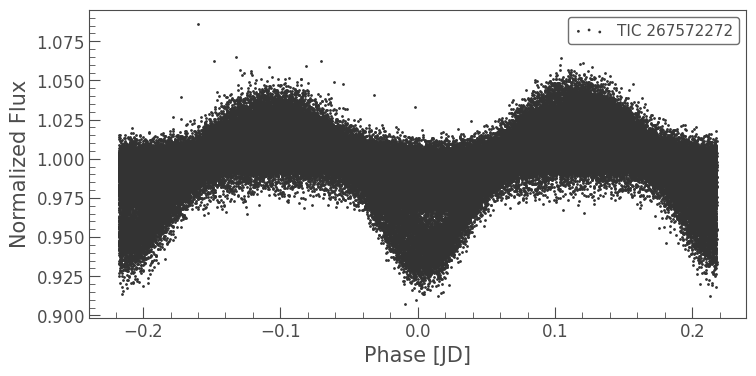

In [20]:
# plot the phase folded data using the peak of the periodogram of the composite light curve (ie ALL the sectors together)
# big_lc.fold(period=2.*average_period).scatter();
folded_composite_lc = composite_lc.fold(period=composite_EB_period, epoch_time=EB_t0_BTJD)  # folded at 0.4354654125872251 d
folded_composite_lc.scatter();

Folding at this period is not correctly capturing the Eclipsing Binary (EB)... we will instead calculate the LS for each sector and use the average to fold the data

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0.98, 'EB period = 0.43541546498233497 d using 9.0 Sectors')

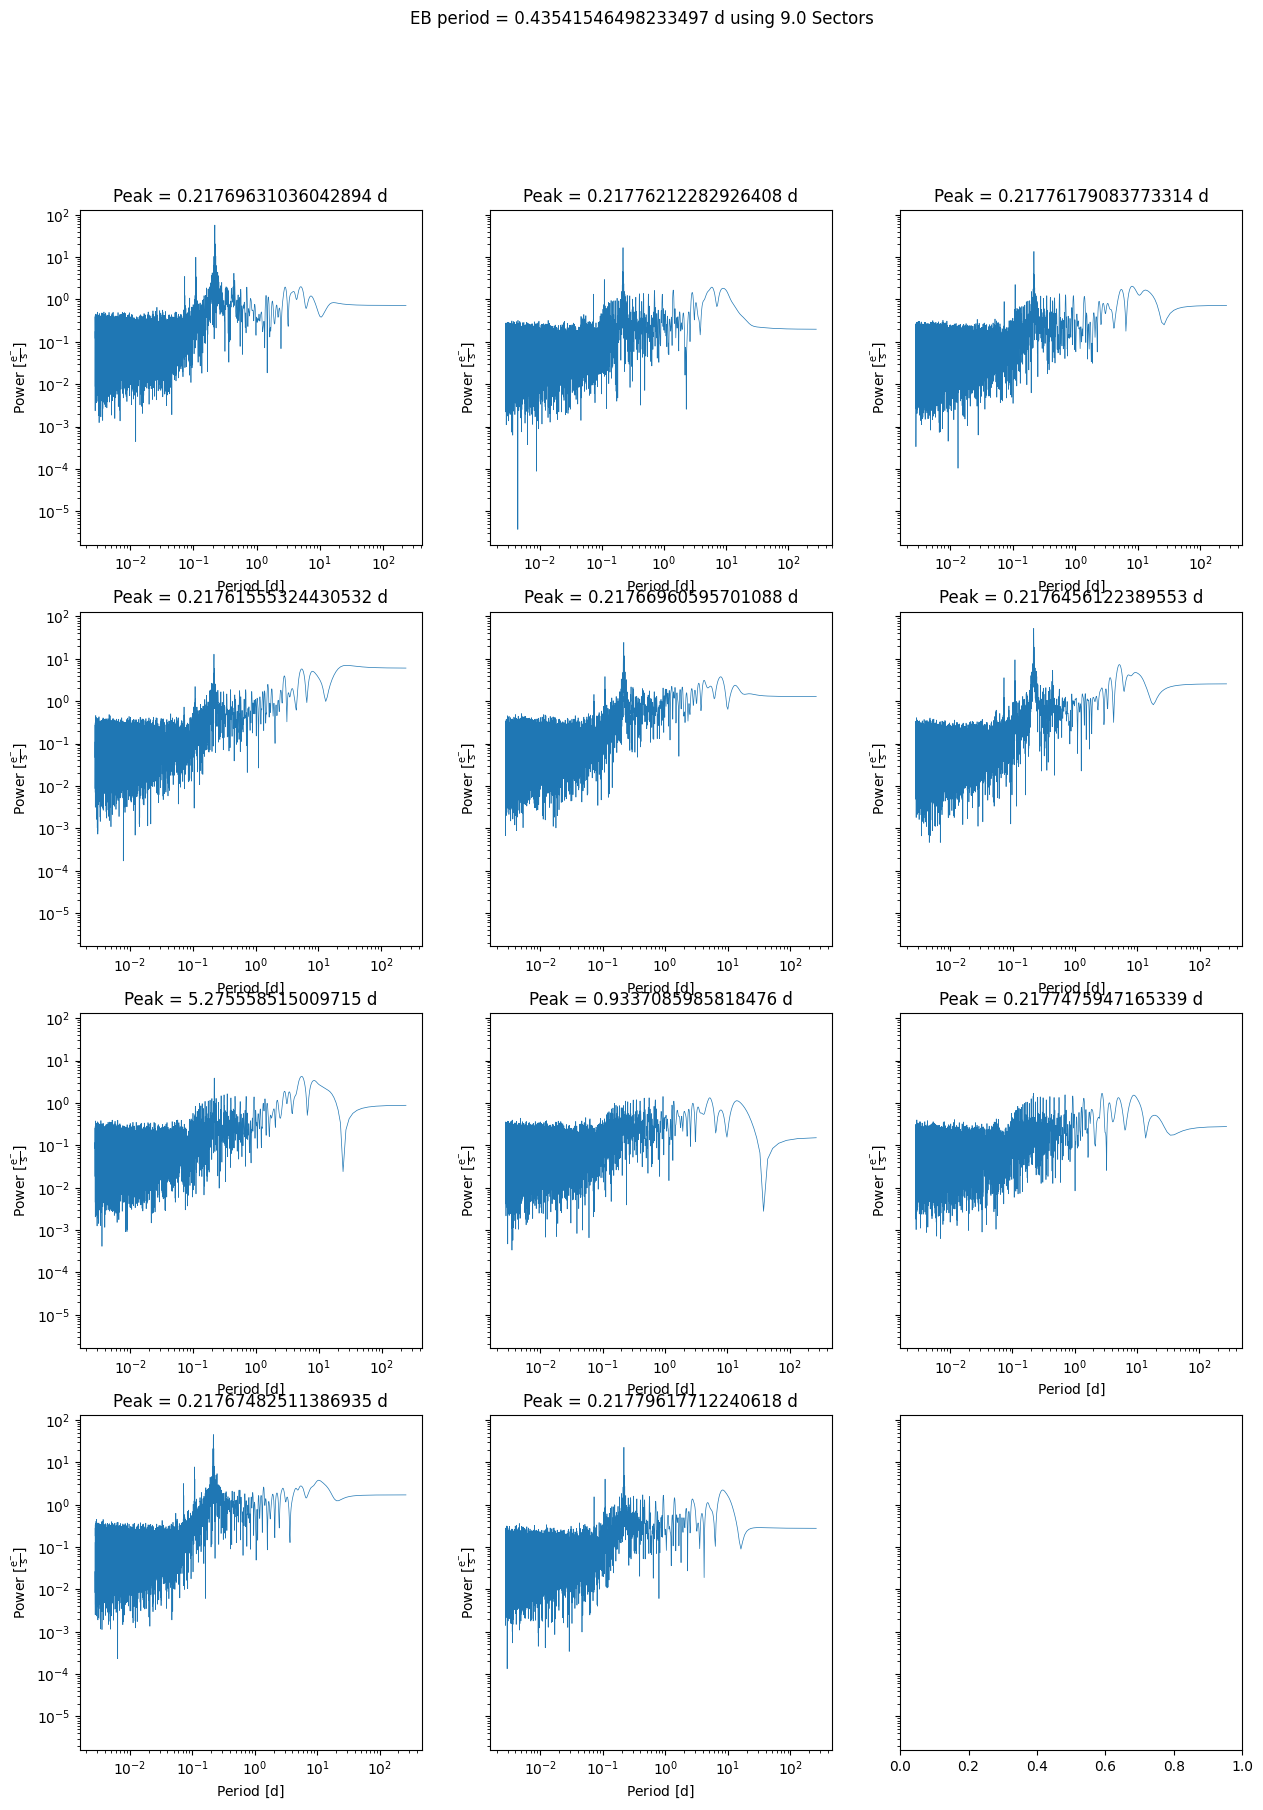

In [21]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period = 0
num_sectors_used = 0
for i, lc in enumerate([*tess_lc_collection]):
    pg = lc.to_periodogram(oversample_factor=10)
    pg.plot(view='period', scale='log', ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    if pg.period_at_max_power >= Quantity(0.4, "day"):  # do not include poorly-behaved data (i.e. sectors 59 & 74)
        pass
    else:
        average_period += pg.period_at_max_power
        num_sectors_used += 1.
# after calculating the peakfor each sector, divde by number of sectors to get the average period
average_period /= num_sectors_used 

# periods for each sector (4/7 - BJ)
# 0 26 0.21769631036042894 d
# 1 40 0.21776212282926408 d
# 2 41 0.21776179083773314 d
# 3 53 0.21761555324430532 d
# 4 54 0.21766960595701088 d
# 5 55 0.2176456122389553 d
# 6 59 5.275558515009715 d
# 7 74 0.9337085985818474 d
# 8 75 0.2177475947165339 d
# 9 80 0.21767482511386935 d
# 10 82 0.21779617712240618 d

# BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
# so we need to fold on twice on the period
LS_EB_period = average_period * 2.
fig.suptitle(f"EB period = {LS_EB_period} using {num_sectors_used} Sectors")

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


26 0.21769631036042894 d
40 0.21776212282926408 d
41 0.21776179083773314 d
53 0.21761555324430532 d
54 0.21766960595701088 d
55 0.2176456122389553 d
75 0.2177475947165339 d
80 0.21767482511386935 d
82 0.21779617712240618 d
9
average period:  0.21770773249116748 d
EB period:  0.43541546498233497 d


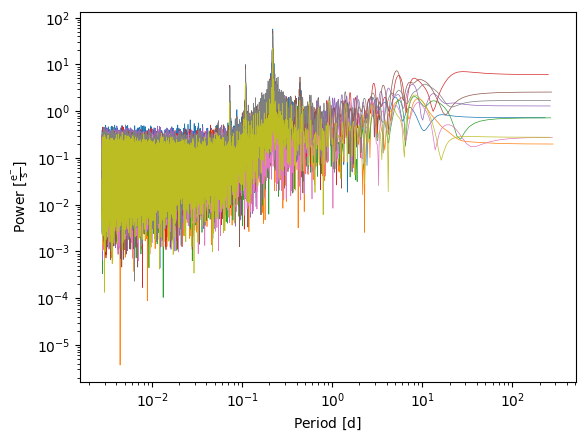

In [22]:
# DO NOT run this cell & the cell above, they result in the same average period, just a matter of viewing preference
# OPTIONAL: Plot all periodograms on the same set of axes removing bad sectors first (BJ-4/7)

fig = plt.figure()
ax = fig.add_subplot(111)

# Sectors 59 and 74 show an anomalous peak at long periods, so we'll mask them out for the purposes of estimating the period.
average_period = 0.
wellbehaving_list = [*tess_lc_collection[:6], *tess_lc_collection[8:]]  # (4/8 RH) Changed index from 5 to 6, python indexing is NON-inclusive and we threw out too many sectors (3 instead of two)
for cur_lc in wellbehaving_list:

    # We'll focus on the SAP flux because it has the least processing.
    cur_lc.select_flux("pdcsap_flux")

    # Calculate periodogram
    pg = cur_lc.to_periodogram(oversample_factor=10) 
    # help(big_lc.to_periodogram)
    pg.plot(view='period', scale='log', ax=ax);
    # Find peak - 0.21769631036042894 d
    # 
    # BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
    # so we need to fold on twice on the period
    print(cur_lc.sector, pg.period_at_max_power)

    average_period += pg.period_at_max_power

average_period /= len(wellbehaving_list)
print(len(wellbehaving_list))
print(f"average period: ", average_period)
print(f"EB period: ", 2.*average_period)

# ax.set_xlim([1e-1, 1e0])
ax.get_legend().remove()
ax.set_yscale('log')



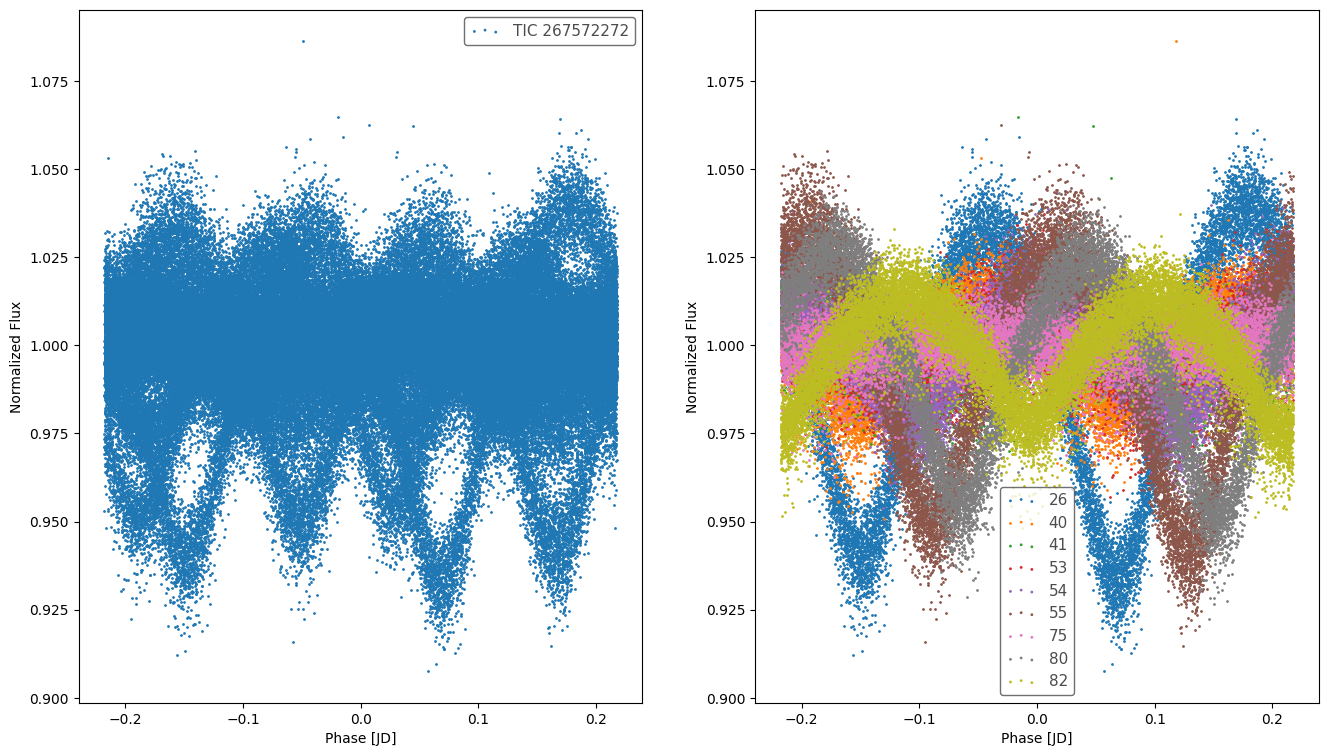

In [23]:
# fold and plot each sector on top of one another
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
avg_folded_composite = composite_lc.fold(period=LS_EB_period)
avg_folded_composite.scatter(ax=ax1, normalize=True);
for lc in wellbehaving_list:
    folded_lc = lc.fold(period=LS_EB_period)
    folded_lc.scatter(ax=ax2, label=folded_lc.sector, normalize=True);

# NOTE: the final folded light curve from 4/7 experiments was only from ONE sector... need to find better way to align them

Now, we will test what the folded data looks like using Elisbeth's method (Box Least Squares). 

26 0.43543295219823086 d
40 0.4354553673725893 d
41 0.43550139798676607 d
53 0.43512650500162386 d
54 0.43541844674093144 d
55 0.43531218786071135 d
59 2.796216164491639 d
74 2.7978807389073808 d
75 2.795156352624111 d
80 0.43547521363969655 d
82 0.4354603146479749 d


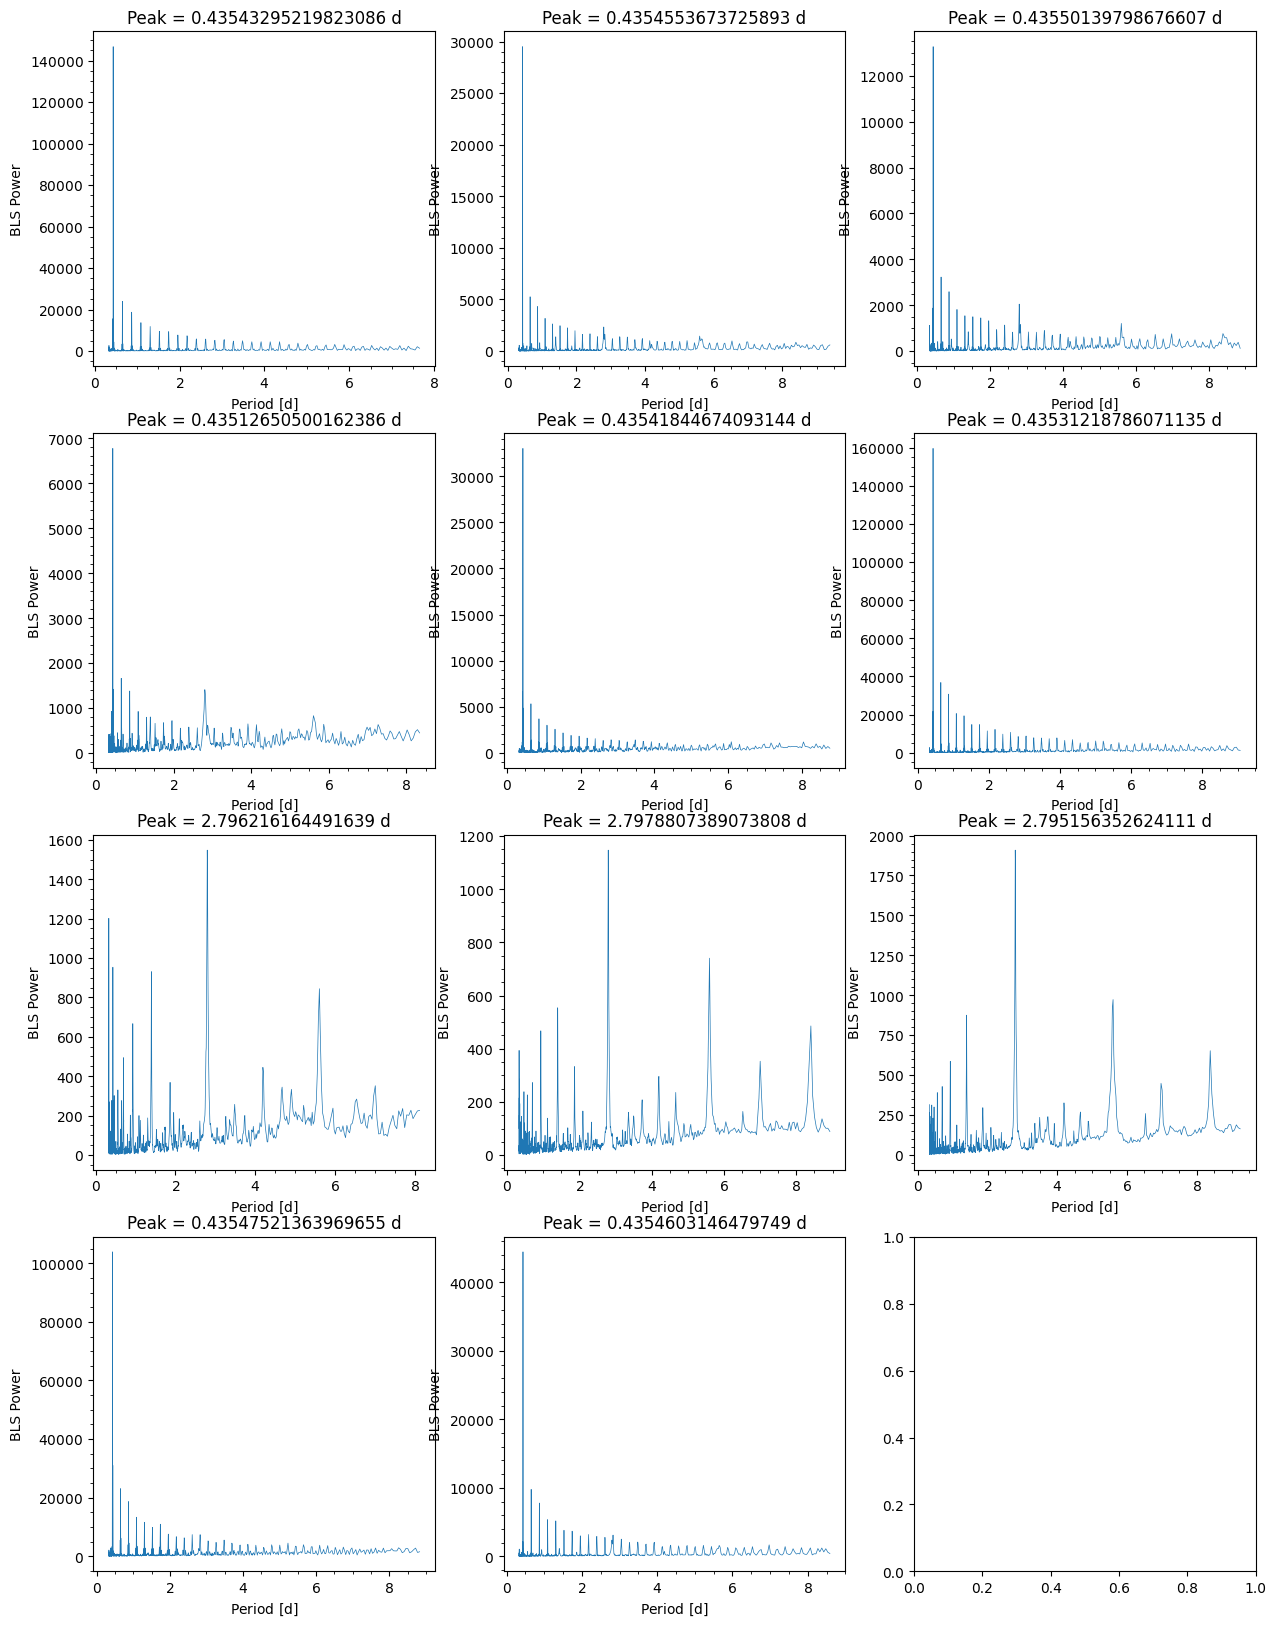

In [35]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period = []
sum_period = 0
BLS_list = []
for i, lc in enumerate([*tess_lc_collection]):
    pg = lc.to_periodogram(method="bls")
    pg.plot(ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    print(lc.sector, pg.period_at_max_power)
    if pg.period_at_max_power >= Quantity(1, "day"):  # do not include data that captures planet's period
        pass
    else:
        average_period.append(pg.period_at_max_power)
        sum_period += pg.period_at_max_power
        BLS_list.append(lc)
# after calculating the peakfor each sector, divde by number of sectors to get the average period
# average_period /= len(BLS_list) 

# periods for each sector 
# 26 0.43543295219823086 d
# 40 0.4354553673725893 d
# 41 0.43550139798676607 d
# 53 0.43512650500162386 d
# 54 0.43541844674093144 d
# 55 0.43531218786071135 d
# 59 2.796216164491639 d
# 74 2.7978807389073808 d
# 75 2.795156352624111 d
# 80 0.43547521363969655 d
# 82 0.4354603146479749 d

# the box least squares plot pick sup on the full EB period, so we do not need to multiply it by 2
BLS_EB_period = average_period # this is a list and needs to be iterated through. Changed so that I could fit each light curve individually
# fig.suptitle(f"EB period = {BLS_EB_period} using {num_sectors_used} Sectors")

0.43539779818106555 d


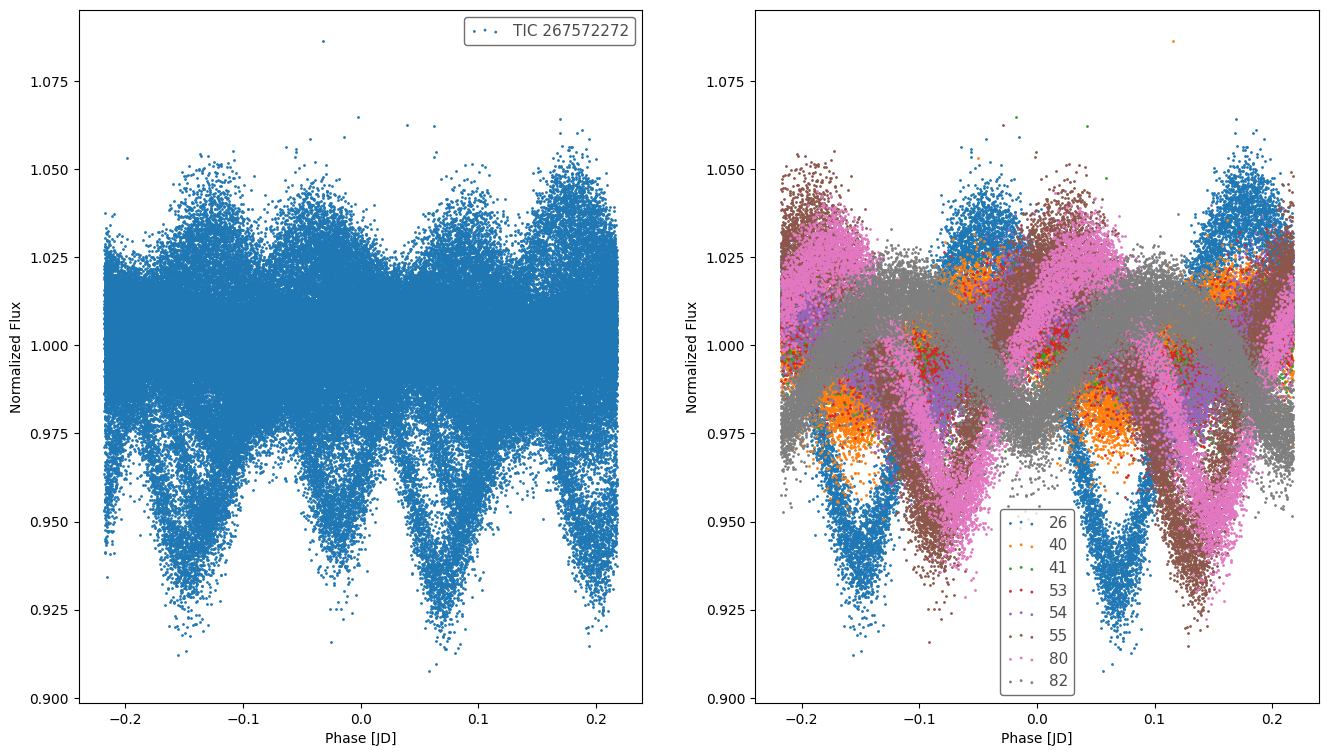

In [176]:
# for each sector that returns a period appropriate for the binary, fold according to the average EB period and plot
BLS_average_period = sum_period  / len(BLS_list)
print(BLS_average_period)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
bls_avg_folded_composite = composite_lc.fold(period=BLS_average_period)
bls_avg_folded_composite.scatter(ax=ax1, normalize=True);
for i, lc in enumerate(BLS_list):
    folded_lc = lc.fold(period=BLS_EB_period[i])
    folded_lc.scatter(ax=ax2, label=folded_lc.sector, normalize=True);

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

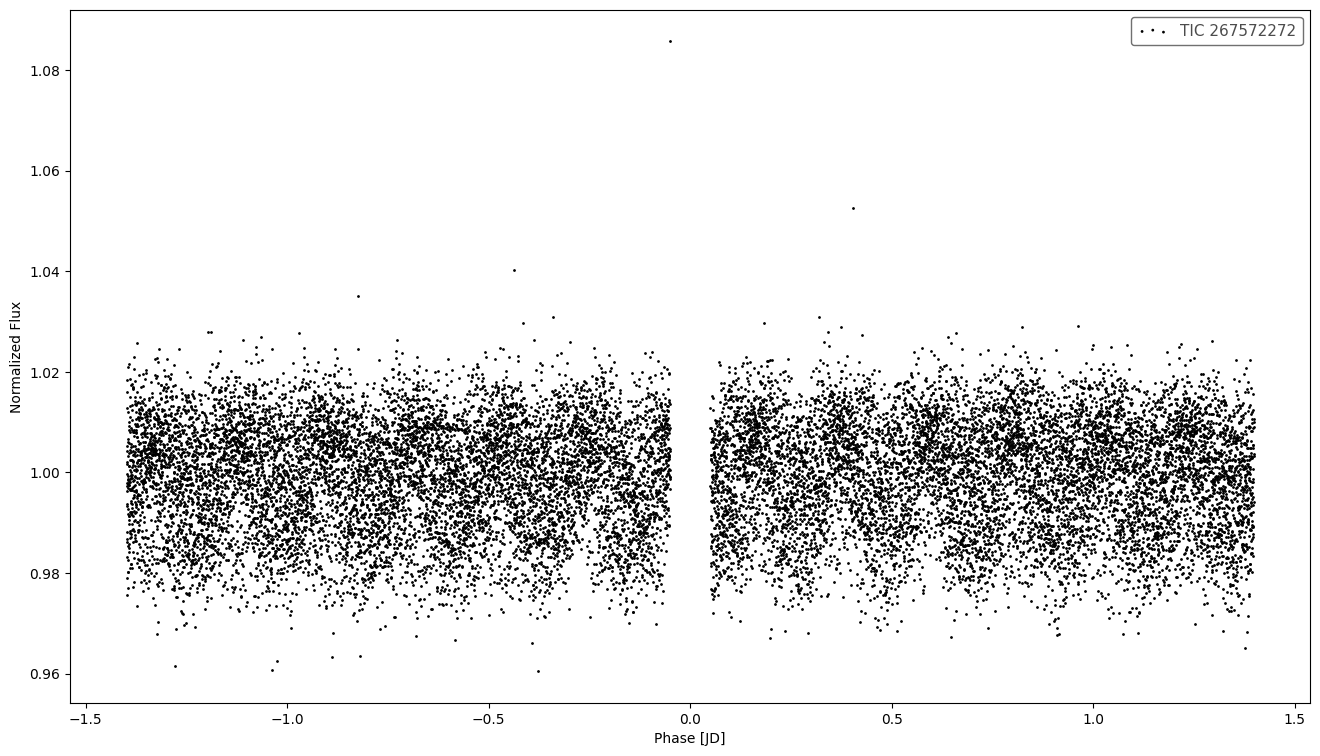

In [308]:
# create a transit mask
sec40 = BLS_list[1]
known_transit_mask = sec40.create_transit_mask(transit_time=epoch_0_BTJD, 
                                                   period=orbital_period,
                                                   duration=0.1)
known_transits_lc = sec40[known_transit_mask] # this light curve object is JUST the transits.
no_transit_mask = known_transit_mask == False  # this inverts the mask to mask out ONLY the transits
NO_transits_lc = sec40[no_transit_mask]

# fold lcs
fold_T_sec40 = sec40.fold(period=orbital_period, epoch_time=epoch_0_BTJD)
fold_T_no_transits = NO_transits_lc.fold(period=orbital_period, epoch_time=epoch_0_BTJD)

fig = plt.figure(figsize=(16,9))
ax3=fig.add_subplot(111)
# fold_T_sec40.scatter(ax=ax3)
fold_T_no_transits.scatter(ax=ax3, color='k', normalize=True)


(2390.0, 2395.0)

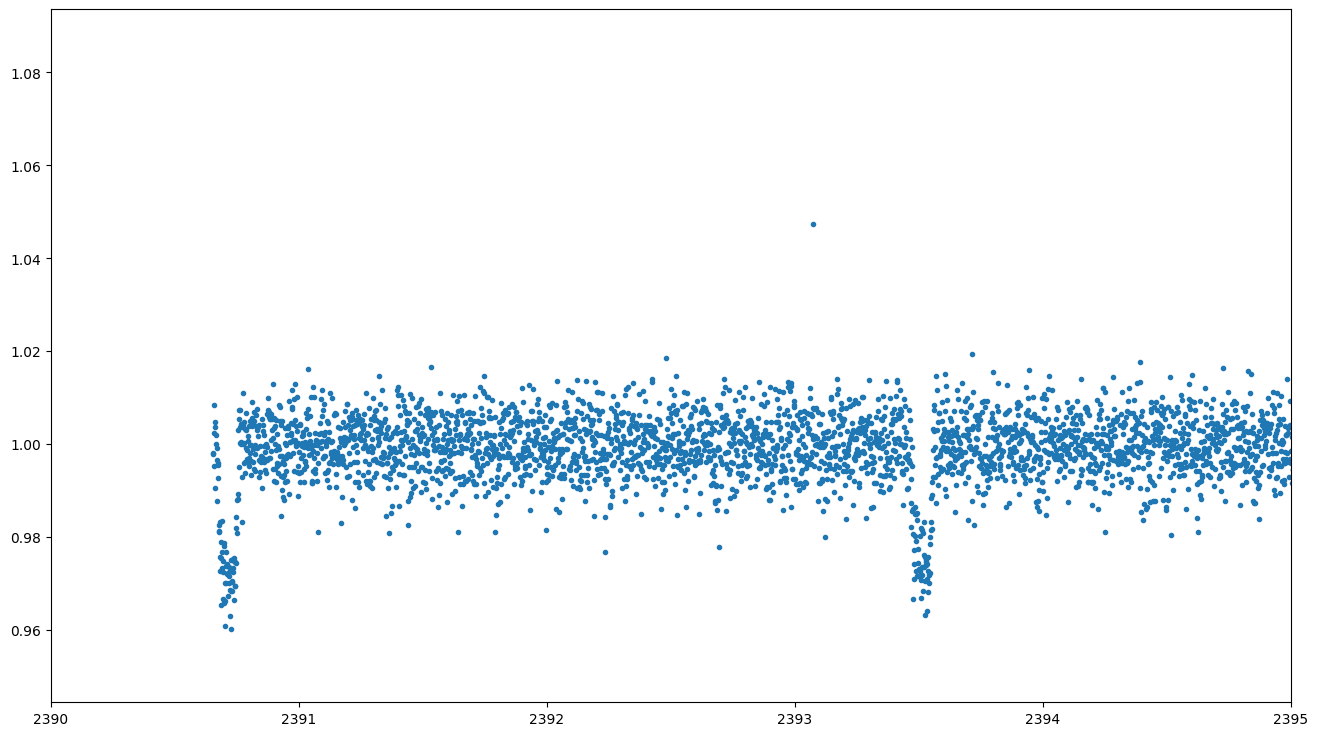

In [310]:
fig = plt.figure(figsize=(16,9))
ax3=fig.add_subplot(111)

flat_no_transit, trend_lc = NO_transits_lc.flatten(window_length=101, return_trend=True)
# flat_no_transit.scatter(ax=ax3)

interp_trend = np.interp(sec40.time.value, trend_lc.time.value, trend_lc.flux.value)

# ax3.scatter(trend_lc.time.value, trend_lc.flux.value)
# ax3.scatter(sec40.time.value, interp_trend)

# ax3.set_xlim([2390, 2395])

all_flat = sec40.flux.value / interp_trend

# ax3.scatter(sec40.time.value % orbital_period, all_flat, marker='.')
ax3.scatter(sec40.time.value, all_flat, marker='.')
ax3.set_xlim([2390, 2395])

AttributeError: 'NoneType' object has no attribute 'remove'

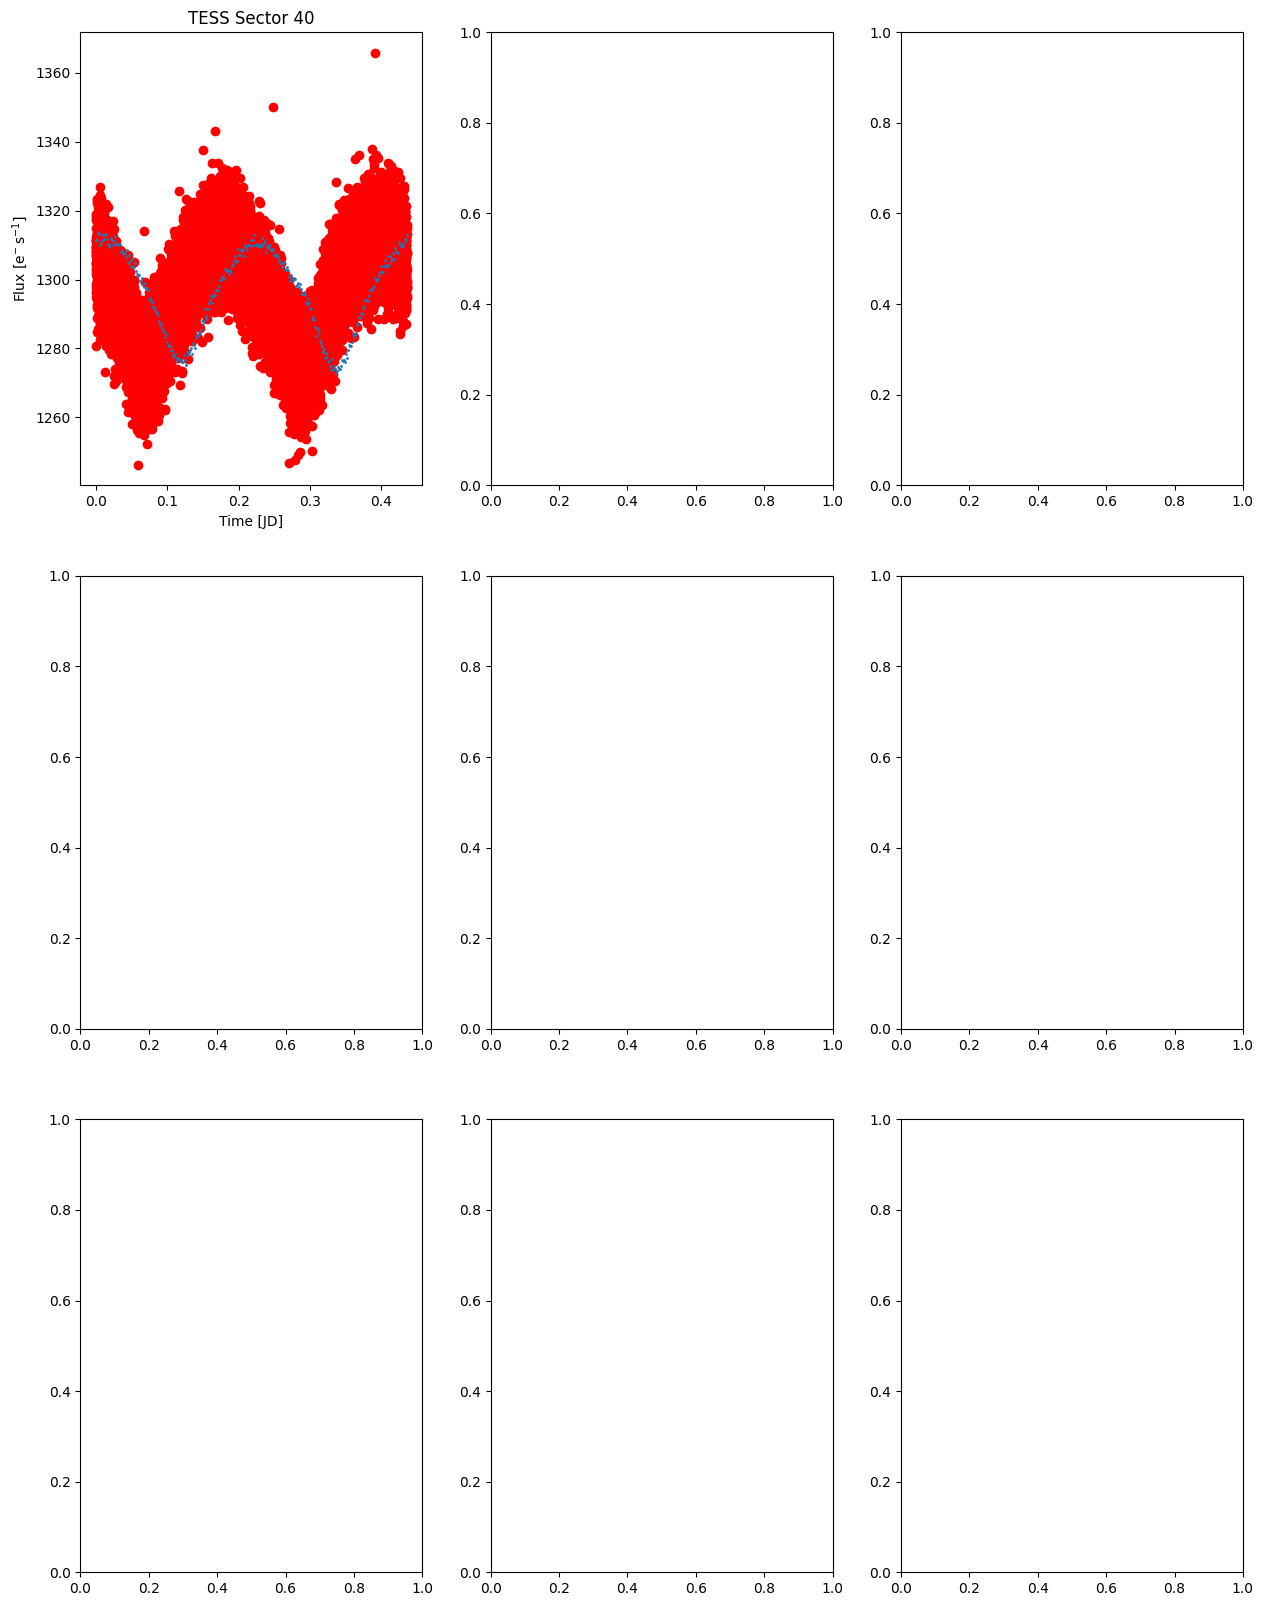

In [ ]:
# Try phase folding each sector individually. 
fig, axs = plt.subplots(3, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
binsize = 120./86400. # 120 seconds to days

folded_list = []
binned_folded_list = []
for i, lc in enumerate([NO_transits_lc]):
    folded_lc = lc.fold(period=BLS_EB_period[1])  # with no epoch_time specificed this defaults to the first time in the series
    folded_lc_shift = lk.LightCurve(time=folded_lc.time - np.min(folded_lc.time), flux=folded_lc.flux, flux_err=folded_lc.flux_err)
    handfold = lc.time.value % BLS_EB_period[1].value
    folded_list.append(folded_lc_shift)
    binned_folded_lc = folded_lc_shift.bin(binsize)
    binned_folded_list.append(binned_folded_lc)
    binned_folded_lc.scatter(ax=axs[ax_indices[i]])
    axs[ax_indices[i]].scatter(handfold, lc.flux, color="r", zorder=-1)
    axs[ax_indices[i]].set_title(f"TESS Sector {folded_lc.sector}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

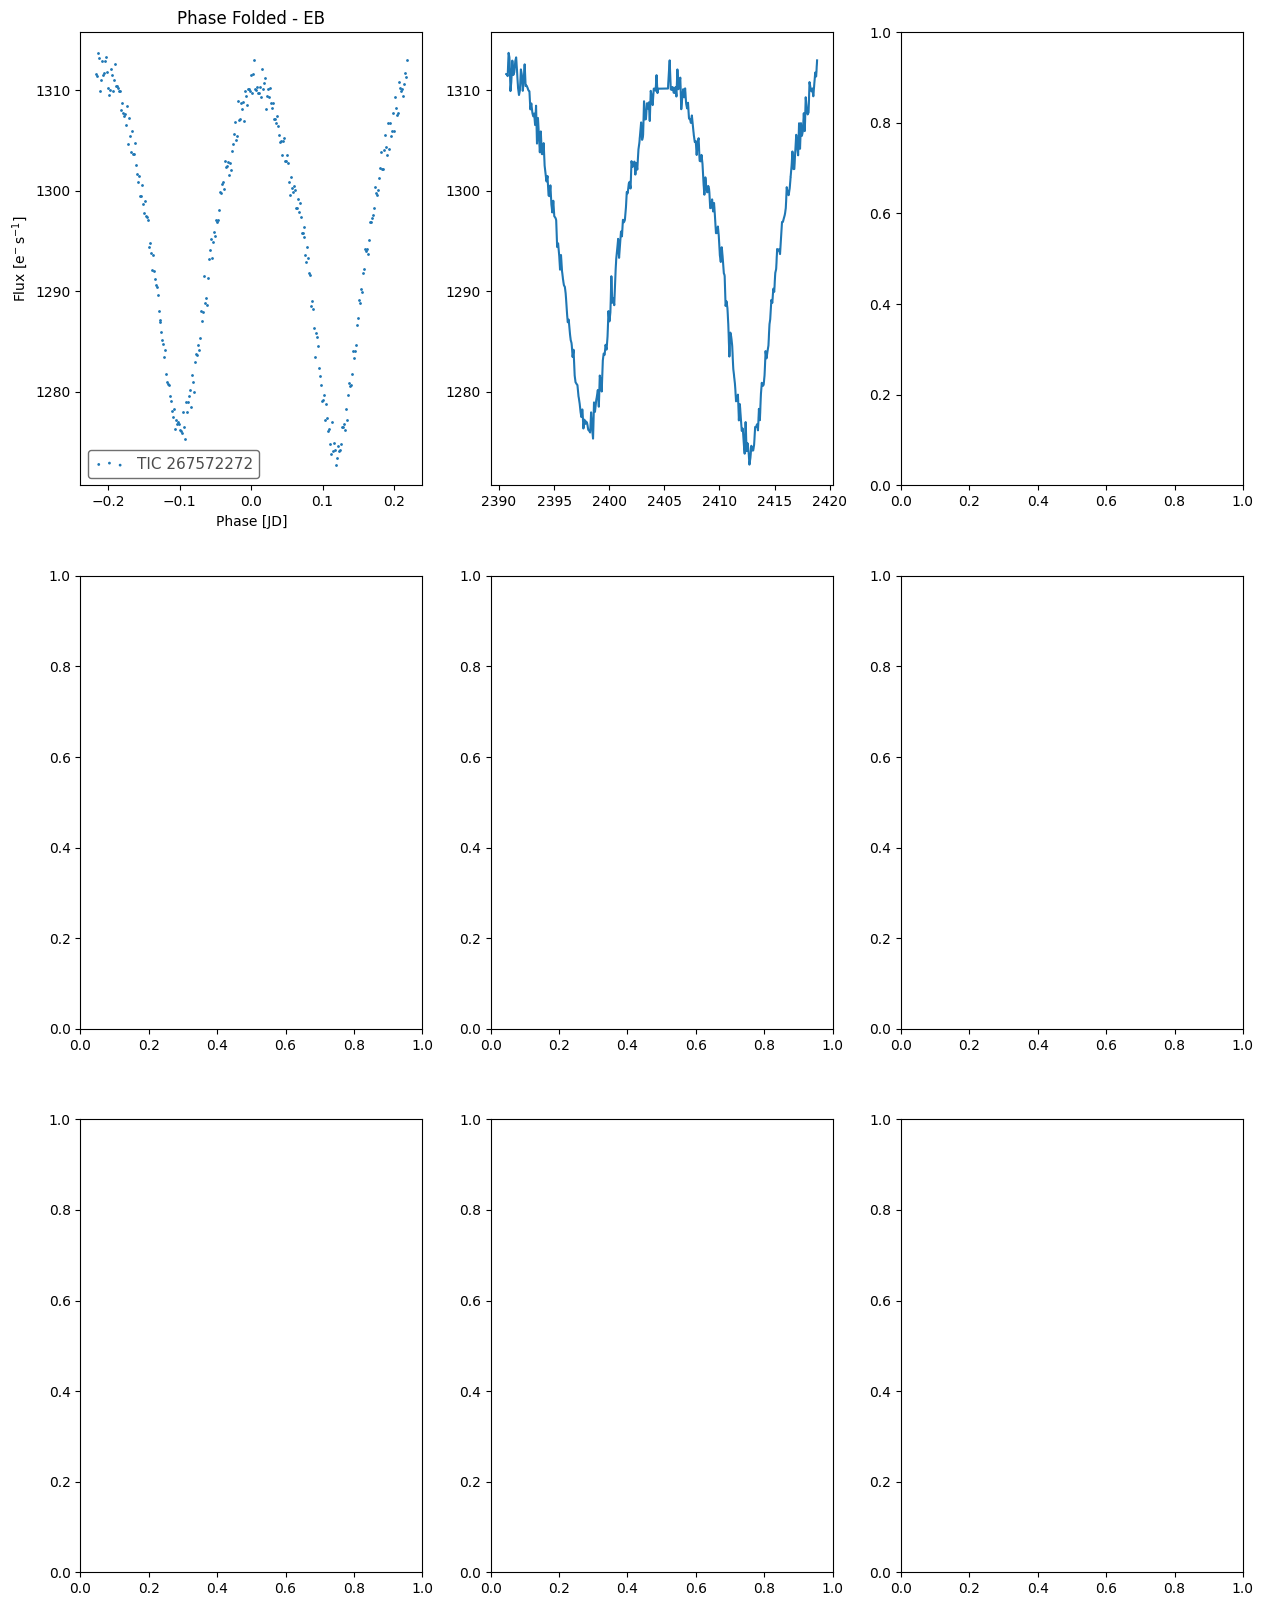

In [263]:
# interp, flatten and compare
fig, axs = plt.subplots(3, 3, figsize=(15, 20)) #, sharey='row') # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
for i, lc in enumerate([BLS_list[1]]):  # note use folded_list / binned_foldeded_list too!
    binned_folded_list[i].scatter(ax=axs[i, 0]) #, normalize=True)
    axs[i, 0].set_title("Phase Folded - EB")
    fold_sec_40 = sec40.fold(period=BLS_EB_period[1], epoch_time=NO_transits_lc.time.value[0])
    interp_y = np.interp(fold_sec_40.time.value, binned_folded_list[i].time.value, binned_folded_list[i].flux.value)
    # interp_y = np.interp(sec40.time.value, binned_folded_list[i].time.value, binned_folded_list[i].flux.value)

    axs[i, 1].plot(sec40.time.value, interp_y)
    flatten_y = sec40.flux.value / interp_y  # need to have the transit in here
    # print("original: ", np.min(lc.flux.value), np.max(lc.flux.value))
    # print("interp: ", np.min(interp_y), np.max(interp_y), len(np.unique(interp_y)))
    # print("flat: ", np.min(flatten_y), np.max(flatten_y))
    # print()
    # flattened_curve = lk.LightCurve(time=sec40.time, flux=Quantity(flatten_y, 'electron / s'), flux_err=sec40.flux_err)
    # flattened_folded_EB = flattened_curve.fold(period=BLS_EB_period[1])
    # flattened_folded_EB.scatter(ax=axs[i, 1])  #, color='k', label="Divide by EB signal")
    # axs[i, 1].set_title(f"TESS Sector {lc.sector}")

    # folded_flat_curve = flattened_curve.fold(period=orbital_period, epoch_time=epoch_0_BTJD)
    # bin_fold_flat_curve = folded_flat_curve.bin(binsize)
    # folded_flat_curve.scatter(ax=axs[i, 2])
    # axs[i, 2].set_title("Transit Folded")

In [ ]:
# we will use a 5th order fourier series to fit the data. 
# Define a 5th-order Fourier series model
def fourier_series(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5):
    return (a0 +
            a1 * np.cos(1 * x) + b1 * np.sin(1 * x) +
            a2 * np.cos(2 * x) + b2 * np.sin(2 * x) +
            a3 * np.cos(3 * x) + b3 * np.sin(3 * x) +
            a4 * np.cos(4 * x) + b4 * np.sin(4 * x) +
            a5 * np.cos(5 * x) + b5 * np.sin(5 * x))
true_params = [1, 0.5, 0.2, -0.3, 0.1, 0.5, -0.1, 0.3, 0.4, 0.2, -0.5]  # True Fourier coefficients

In [ ]:
# DO NOT DO!
# find  functional form for each sector EB signal
fig, axs = plt.subplots(3, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
popt_fourier_bf_data = []
fourier_fits = []
for i, lc in enumerate(binned_folded_list):
    # we have to shift the dat so that it fits on the 0 to 2pi range
    # this only works because we know we have folded for one period of data
    phase = lc.time.value
    phase_0 = phase - np.min(phase)
    phase_factor = (2*np.pi) / phase_0[-1]
    fit_x = phase_0 * phase_factor

    #use curve_fit to fit to fourier series
    popt, pcov = curve_fit(fourier_series, fit_x, lc.flux.value, p0=true_params)
    print(popt)
    popt_fourier_bf_data.append(popt)

    lc.scatter(ax=axs[ax_indices[i]])
    new_x = np.linspace(0, 2*np.pi, len(phase), endpoint=True)
    new_y = fourier_series(fit_x, *popt)
    fourier_fits.append(new_y)
    axs[ax_indices[i]].plot(phase, new_y, '-', color='k', label="Fourier Series Fit")
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.


original:  1129.7065 1324.7098
interp:  1162.326663709209 1291.380692312413 16678
flat:  0.9631960933852609 1.037165032745361

original:  1233.0792 1408.8568
interp:  1273.6260296173955 1310.9125491373068 19297
flat:  0.9617460885420809 1.085458254099942

original:  1281.1338 1423.5162
interp:  1319.1981363846487 1349.2776970041969 18033
flat:  0.9666101205166091 1.0591404627836698



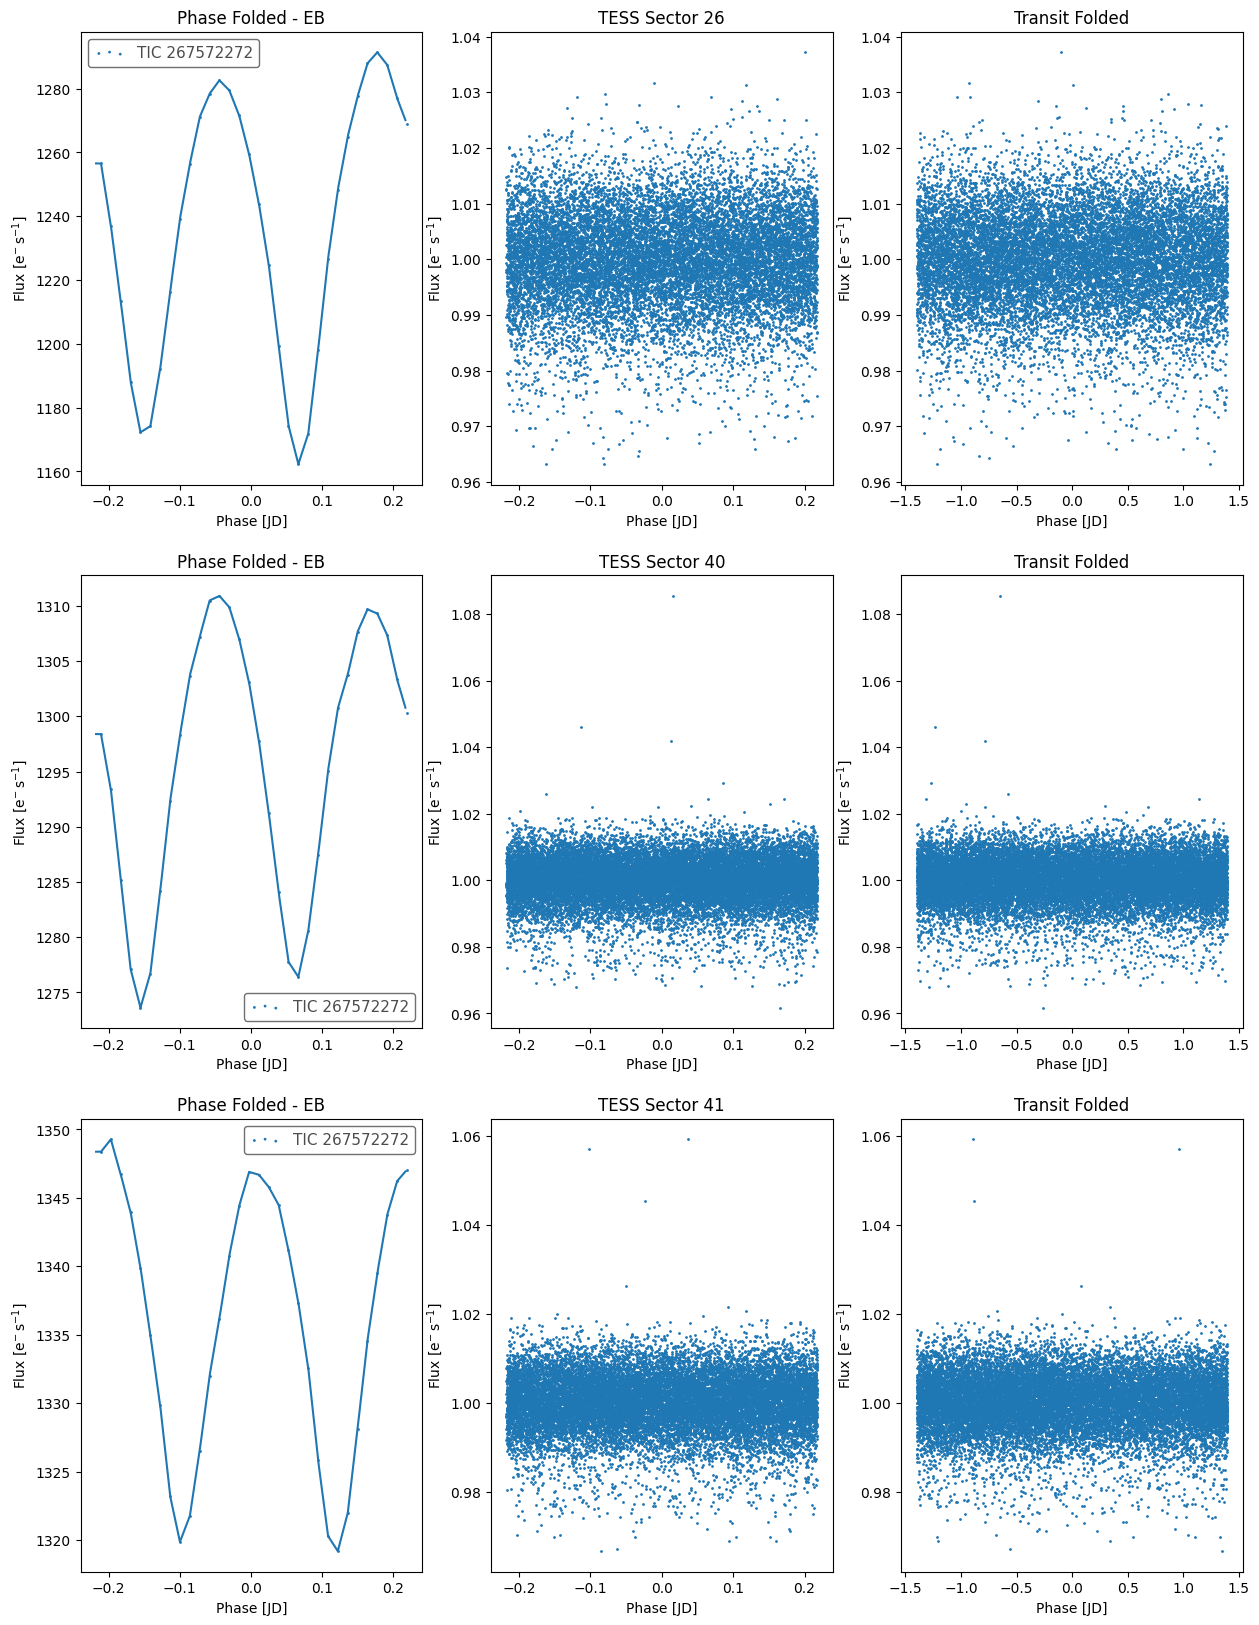

In [230]:
# interp, flatten and compare
fig, axs = plt.subplots(3, 3, figsize=(15, 20)) #, sharey='row') # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
for i, lc in enumerate(BLS_list[:3]):  # note use folded_list / binned_foldeded_list too!
    binned_folded_list[i].scatter(ax=axs[i, 0]) #, normalize=True)
    axs[i, 0].set_title("Phase Folded - EB")
    interp_y = np.interp(folded_list[i].time.value, binned_folded_list[i].time.value, binned_folded_list[i].flux.value)
    axs[i, 0].plot(folded_list[i].time.value, interp_y)
    flatten_y = folded_list[i].flux.value / interp_y
    print("original: ", np.min(lc.flux.value), np.max(lc.flux.value))
    print("interp: ", np.min(interp_y), np.max(interp_y), len(np.unique(interp_y)))
    print("flat: ", np.min(flatten_y), np.max(flatten_y))
    print()
    flattened_curve = lk.LightCurve(time=lc.time, flux=Quantity(flatten_y, 'electron / s'), flux_err=lc.flux_err)
    flattened_folded_EB = flattened_curve.fold(period=BLS_EB_period[i])
    flattened_folded_EB.scatter(ax=axs[i, 1])  #, color='k', label="Divide by EB signal")
    axs[i, 1].set_title(f"TESS Sector {lc.sector}")

    folded_flat_curve = flattened_curve.fold(period=orbital_period, epoch_time=epoch_0_BTJD)
    bin_fold_flat_curve = folded_flat_curve.bin(binsize)
    folded_flat_curve.scatter(ax=axs[i, 2])
    axs[i, 2].set_title("Transit Folded")
    
    # axs.get_legend().remove()  # Suppress the legend because it clutters up the plot.

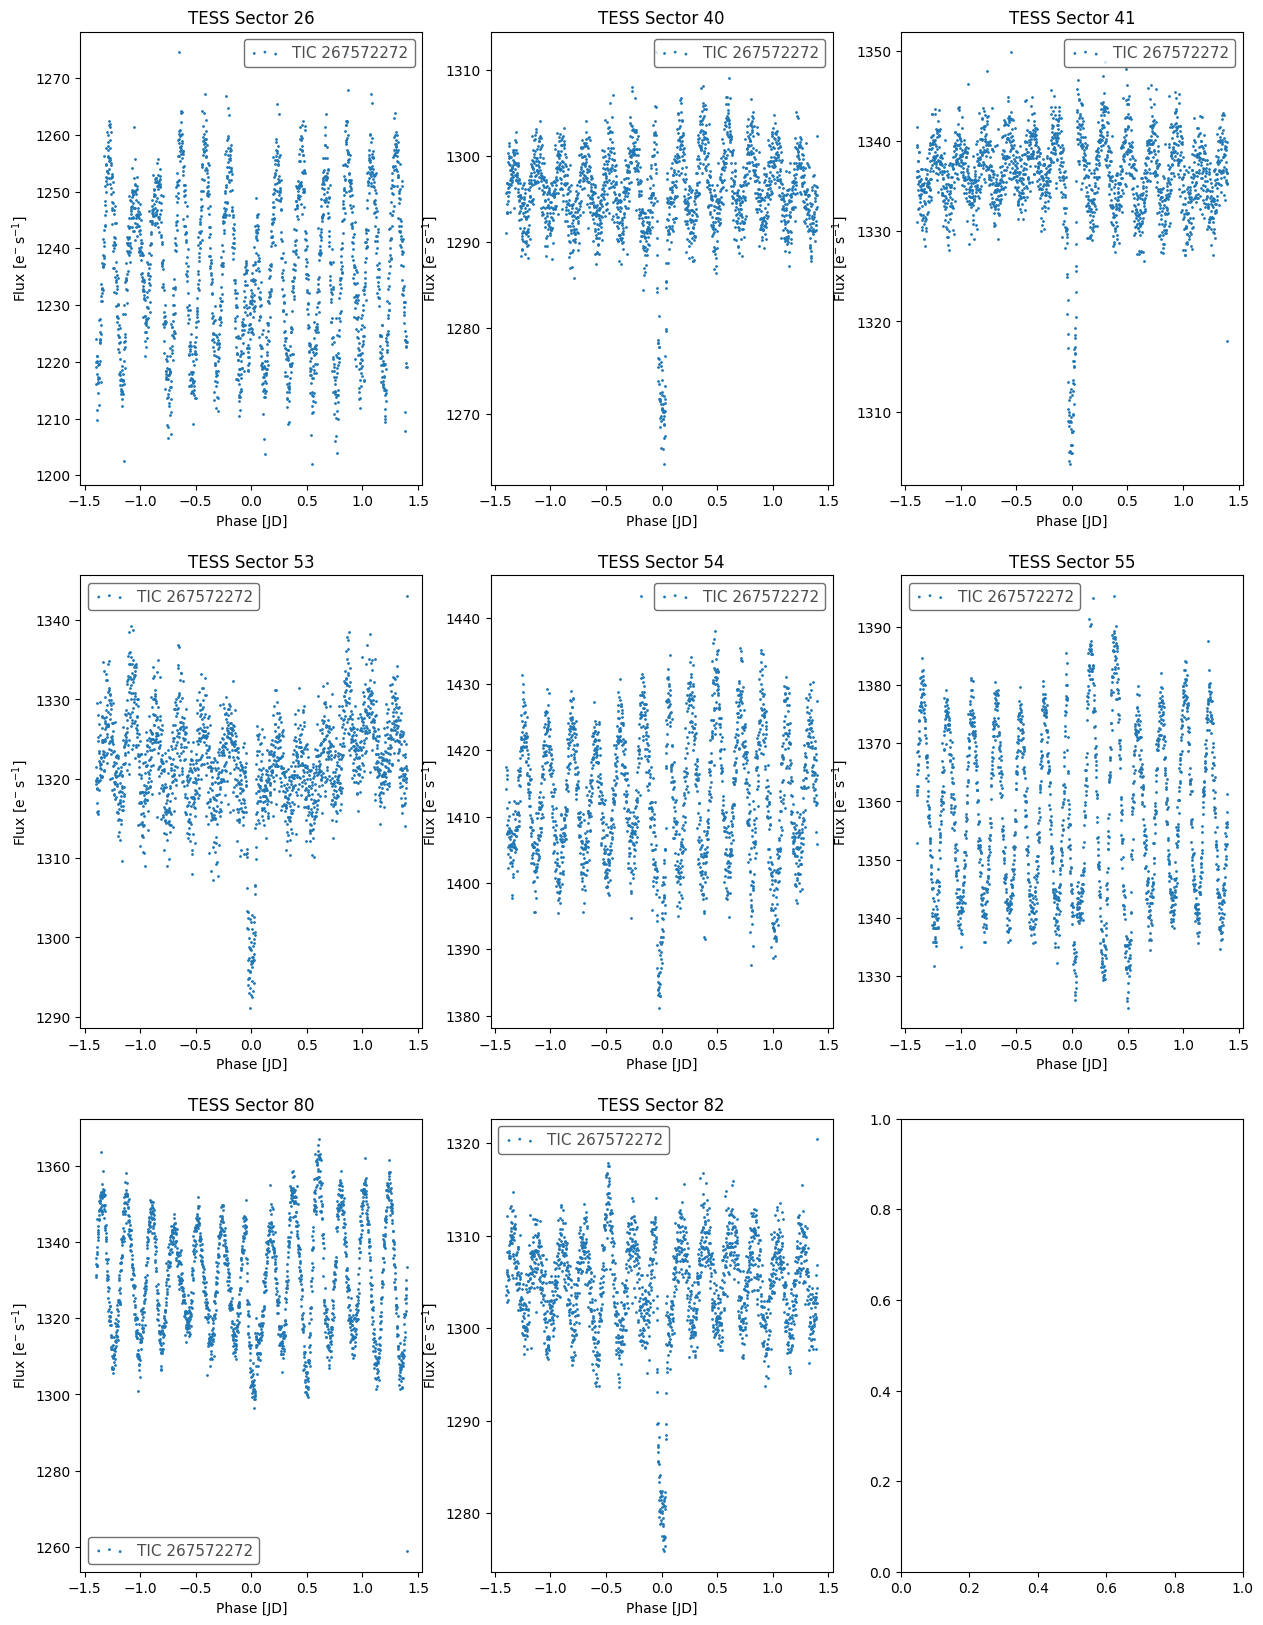

In [202]:
# finally, use the fourier transform function to divide through FULL sector data to remove the EB

fig, axs = plt.subplots(3, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
# popt_fourier_bf_data

for i, lc in enumerate(BLS_list):  # full sector light curves that are contaiminated by the EB
    # First plot all the sectors folded to the transit period. 
    transit_folded_lc = lc.fold(period=orbital_period, epoch_time=epoch_0_BTJD)  # by not defining an epoch_time, we make it so that the EB fold and transit fold start at the same time
    # transit_folded_lc.scatter(ax=axs[ax_indices[i]])
    transit_binned = transit_folded_lc.bin(binsize)
    transit_binned.scatter(ax=axs[ax_indices[i]])
    
    # how many EB phases are in a transit phase
    # print(average_period[i])
    EB_per_transit = orbital_period / average_period[i].value
    # print(f"There are {EB_per_transit} eclipses in one transit period of Sector {transit_folded_lc.sector}")
    # new_x = np.linspace(0, EB_per_transit*2*np.pi, len(transit_folded_lc.time.value), endpoint=True)  # we create a grid across the phase space we need with the length to match the data
    # fit_y = fourier_series(new_x, *popt_fourier_bf_data[i])
    # axs[ax_indices[i]].plot(transit_folded_lc.time.value, fit_y, '-', color='k', label="Fourier Series Fit")

    # flat_y = transit_folded_lc.flux / fit_y
    # axs[ax_indices[i]].plot(transit_folded_lc.time.value, flat_y, '-', color='r', label="Flattened")
    # print("Completed Sector ", transit_folded_lc.sector)
    
    # popt, pcov = curve_fit(fourier_series, fit_x, lc.flux.value, p0=true_params)
    # popt_fourier_bf_data.append(popt)

    # lc.scatter(ax=axs[ax_indices[i]])
    # new_x = np.linspace(0, 2*np.pi, 314, endpoint=True)
    # axs[ax_indices[i]].plot(phase, fourier_series(new_x, *popt), '-', color='k', label="Fourier Series Fit")
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    # axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

0.43539779818106555 d


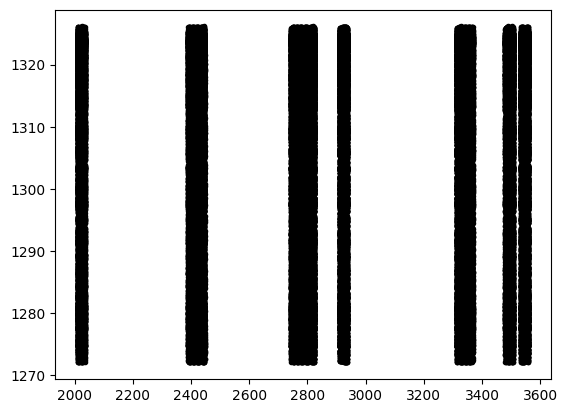

In [203]:
# Interpolate binned_folded_lc
time = composite_lc.time.value
print(BLS_average_period)
folded_time = composite_lc.time.value % BLS_average_period.value
mn_time = np.mean(folded_time)
interpolated_binned_folded_lc = np.interp(folded_time - mn_time, binned_folded_lc.time.value, binned_folded_lc.flux.value)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(time, interpolated_binned_folded_lc, marker='.', color='k')

In [204]:
detrended_big_lc = big_lc.flux.value/interpolated_binned_folded_lc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(big_lc.time.value % orbital_period, detrended_big_lc, marker='.', color='k')

NameError: name 'big_lc' is not defined